In [2]:
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import xmltodict
import konlpy
from konlpy.tag import Okt
import pandas as pd
import numpy as np
import re
from collections import Counter
from matplotlib import rc
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [3]:
import warnings
warnings.filterwarnings('ignore')

# 과제 0726_2
네이버 카테고리별 기사를 아래 카테고리 정의를 기준으로 크롤링한 후 불필요한 공백을 제거하고 한글만으로 된 데이터 프레임을 출력하세요.
(전체, 카테고리별로키워드 분석을 위한 시각화)
- 카테고리 정의
    - 100 정치
        - (청와대[264] + 국회/정당[265] + 북한[268] + 국방/외교[267])

    - 101 경제
        - (금융[259] + 증권[258] + 산업/재계[261] + 글로벌 경제[262] + 부동산[260])

    - 103 생활/문화
        - (건강정보[241] + 여행/레저[237] + 공연/전시[242] + 날씨[248] + 생활문화 일반[245])

    - 105 IT/과학
        - (통신/뉴미디어[227] + IT 일반[230] + 컴퓨터[283] + 과학 일반[228])
        
- 카테고리별 1000개, 총 4천개로 구성된 데이터프레임 생성

# 받은 파일로~

In [73]:
df = pd.read_json('news_df.json')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054 entries, 0 to 3053
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   news      3054 non-null   object
 1   category  3054 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 71.6+ KB


In [25]:
df.category.unique()

array([264, 265, 267, 268, 259, 258, 261, 262, 260, 241, 237, 242, 248,
       245, 227, 230, 283, 228], dtype=int64)

In [27]:
cats = {100 : [264, 265, 268, 267], 101 : [259, 258, 261, 262, 260], 103 : [241, 237, 242, 248, 245], 105 : [227, 230, 283, 228] }

## 100(정치) -> str_100

In [68]:
cats[100]

[264, 265, 268, 267]

In [37]:
df_100 = df[(df.category == 264)|(df.category == 265)|(df.category == 268)|(df.category == 267)]
df_100

,news,category
0,"尹 대통령 ""기업활동 위축시키는 과도한 형벌 규정 개선"" 지시",264
1,"국방부 “유엔사, 판문점 통과 허용…북송 승인 의미는 아냐”",264
2,[포토] 육군 대규모 항공작전 훈련,264
3,尹 유럽에 이어 아세안과도 정상간 비즈니스외교 시작,264
4,"국내 7대 종단 지도자들 ""이명박·이재용·김경수 통큰 사면 요청""",264
...,...,...
687,"""북 아사자 발생, 놀랄 일 아냐""",268
688,"[첫 대정부 질문] ⓛ ""탈북어민 강제북송, 흉악범이어도 잘못된 것""",268
689,"""북 아사자 발생, 놀랄 일 아냐""",268
690,"[첫 대정부 질문] ⓛ ""탈북어민 강제북송, 흉악범이어도 잘못된 것""",268


In [45]:
li_100 = list(df_100.news)
str_100 = ' '.join(li_100)
str_100 = re.sub('[^가-힣]+', ' ', str_100)
str_100

' 대통령 기업활동 위축시키는 과도한 형벌 규정 개선 지시 국방부 유엔사 판문점 통과 허용 북송 승인 의미는 아냐 포토 육군 대규모 항공작전 훈련 유럽에 이어 아세안과도 정상간 비즈니스외교 시작 국내 대 종단 지도자들 이명박 이재용 김경수 통큰 사면 요청 정치 윤대통령 국기 문란 경찰 질타 경찰 내부 반발 고조 대통령 최측근 한동훈 법무장관에 무슨 지시했나 대통령 법무행정 최우선은 경제 살리기 기업 위축하는 형벌규정 개선 문체부 청와대 활용 정부 내 혼선 없어 이미 정리 법무부 업무보고 한동훈 공수처 년 국가 범죄대응 역량 약화 쌍용차 채권단 변제율 상식적이지 않아 대통령에 탄원 브리핑하는 한동훈 법무부장관 항명이냐 강압이냐 대통령과 만 경찰 대치 전선 고조 종합 한동훈에 기업활동 위축 과도한 형벌 개선하라 윤대통령 경찰 집단행동 국기문란 경찰국 신설안 국무회의 통과 검수완박 이전으로 회귀 한동훈에 수사권 강화 보고받아 국내 대 종단 지도자들 이명박 이재용 김경수 통큰 특별사면 탄원 윤 대통령 한동훈에 법무행정 최우선 경제 살리기 당부 한동훈 티타임 부활 지적에 언론으로부터 불편 질문받아야 박홍근 경찰국 신설 이상민 행안부 장관의 행정 쿠데타 포토 육군 이천기지서 열린 대규모 항공작전 한동훈 박범계 검언유착 지적에 전정부는 흘리기 없었나 한동훈 제가 인사 평가 주제 넘어 검증 시스템 안착 고민할 때 법무행정 최우선 경제에 한동훈 이재용 사면 언급 부적절 공수처 대통령 사적 채용 논란 고발 사건 수사 착수 공수처 대통령 사적채용 논란 고발건 수사 부 배당 대통령 기업 활동 위축 과도한 형벌 규정 개선 대통령 복심 한동훈 장관에 기업활동 위축 과도한 형벌규정 개선하라 지시 한동훈 장관에 기업 위축시키는 과도한 형벌 개선하라 뉴스 윤석열 대통령 경찰 집단 반발 국가 기강 문란 그래픽 경찰국 신설 행안부 직제 개정안 국무회의 통과 한동훈 공정과 상식으로 이끌 분이 검찰총장 되길 희망 법무부 업무보고 받는 윤석열 대통령 한동훈 사면 대통령 고유권한 기준 방향 말하는건 

In [54]:
okt = Okt()
list_morph = okt.pos(str_100)
list_noun = []
for word, tag in list_morph:
    if (tag == 'Noun') & (len(word) > 1):
        list_noun.append(word)
print(list_noun)

['대통령', '기업', '활동', '위축', '과도', '형벌', '규정', '개선', '지시', '국방부', '유엔', '판문점', '통과', '허용', '북송', '승인', '의미', '포토', '육군', '대규모', '항공', '작전', '훈련', '유럽', '아세안', '정상', '비즈니스', '외교', '시작', '국내', '종단', '지도자', '이명박', '이재용', '김경수', '통큰', '사면', '요청', '정치', '대통령', '국기', '문란', '경찰', '질타', '경찰', '내부', '반발', '고조', '대통령', '최측근', '한동훈', '법무', '장관', '무슨', '지시', '대통령', '법무', '행정', '우선', '경제', '기업', '위축', '형벌', '규정', '개선', '문체부', '청와대', '활용', '정부', '혼선', '정리', '법무부', '업무', '보고', '한동훈', '국가', '범죄', '대응', '역량', '약화', '쌍용차', '채권', '변제', '상식', '대통령', '탄원', '브리핑', '한동훈', '법무부', '장관', '강압', '대통령', '경찰', '대치', '전선', '고조', '종합', '한동훈', '기업', '활동', '위축', '과도', '형벌', '개선', '대통령', '경찰', '집단', '행동', '국기', '문란', '경찰', '신설', '국무회의', '통과', '수완', '이전', '회귀', '한동훈', '수사권', '강화', '보고', '국내', '종단', '지도자', '이명박', '이재용', '김경수', '통큰', '특별사면', '탄원', '대통령', '한동훈', '법무', '행정', '우선', '경제', '당부', '한동훈', '티타임', '부활', '지적', '언론', '불편', '질문', '박홍근', '경찰', '신설', '이상민', '행안부', '장관', '행정', '쿠데타', '포토', '육군', '기지', '대규모', '항공', '작전', '한동훈

In [56]:
count_words = Counter(list_noun).most_common()
count_words[:10]

[('대통령', 115),
 ('장관', 99),
 ('한동훈', 81),
 ('경찰', 78),
 ('국회', 64),
 ('축하', 62),
 ('박진', 47),
 ('상임', 46),
 ('업무', 43),
 ('보고', 43)]

In [59]:
rc('font', family='Malgun Gothic') # 한글 폰트
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호출력 설정

In [61]:
dict_count=dict(count_words)
sr = pd.Series(dict_count)

In [63]:
df_100 = pd.DataFrame(sr, columns=['cnt'])
df_100 = df.sort_values(by='cnt', ascending=False)[:20]
df_100.reset_index(inplace=True)
df_100.head()

,index,cnt
0,대통령,115
1,장관,99
2,한동훈,81
3,경찰,78
4,국회,64


<AxesSubplot:xlabel='index', ylabel='cnt'>

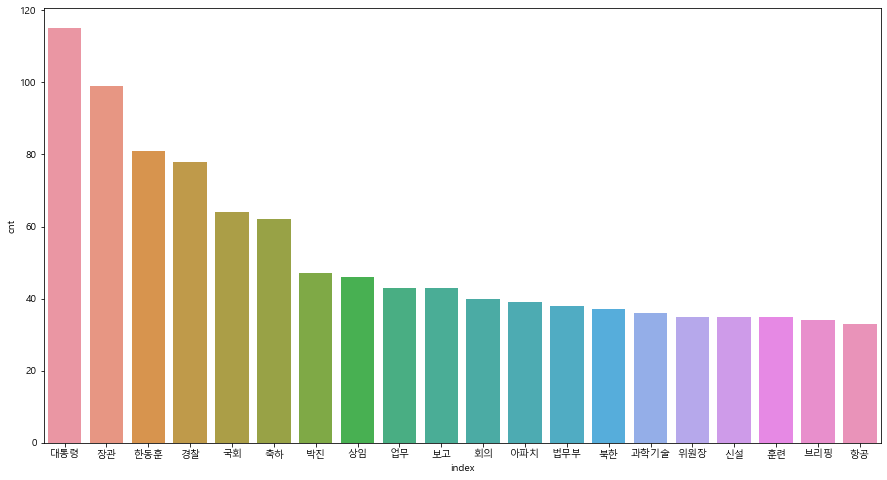

In [64]:
plt.figure(figsize = (15,8))
sns.barplot(x='index', y='cnt', data=df10, orient='v')

In [65]:
wordcloud = WordCloud(font_path = '../03_Visualization/dataset/malgun.ttf', 
                       background_color='white', colormap='winter', 
                       width=1500, height=1500).generate_from_frequencies(dict_count)

(-0.5, 1499.5, 1499.5, -0.5)

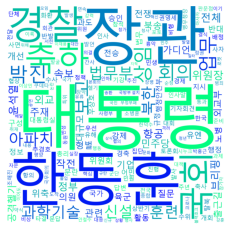

In [66]:
plt.imshow(wordcloud)
plt.axis('off')

## 101(금융) -> str_101

In [70]:
cats

{100: [264, 265, 268, 267],
 101: [259, 258, 261, 262, 260],
 103: [241, 237, 242, 248, 245],
 105: [227, 230, 283, 228]}

In [ ]:
df_101 = df[(df.category == 259)|(df.category == 258)|(df.category == 261)|(df.category == 262)|(df.category == 260)]

li_101 = list(df_101.news)
str_101 = ' '.join(li_101)
str_101 = re.sub('[^가-힣]+', ' ', str_101)
str_101

okt = Okt()
list_morph = okt.pos(str_101)
list_noun = []
for word, tag in list_morph:
    if (tag == 'Noun') & (len(word) > 1):
        list_noun.append(word)
print(list_noun)

count_words = Counter(list_noun).most_common()
count_words[:10]

rc('font', family='Malgun Gothic') # 한글 폰트
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호출력 설정

dict_count_101=dict(count_words)
sr = pd.Series(dict_count_101)

df_101 = pd.DataFrame(sr, columns=['cnt'])
df_101 = df_101.sort_values(by='cnt', ascending=False)[:20]
df_101.reset_index(inplace=True)
df_101.head()

<AxesSubplot:xlabel='index', ylabel='cnt'>

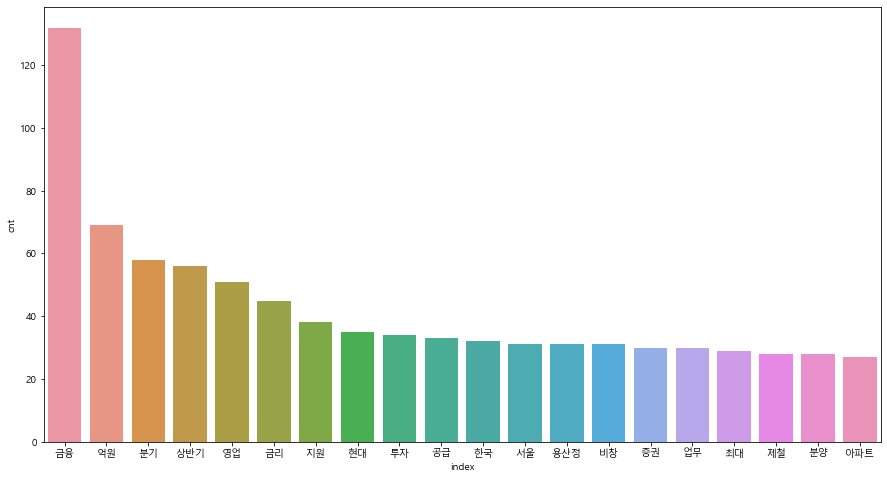

In [76]:
plt.figure(figsize = (15,8))
sns.barplot(x='index', y='cnt', data=df_101, orient='v')

(-0.5, 1499.5, 1499.5, -0.5)

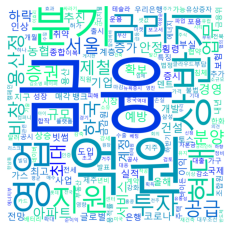

In [77]:
wordcloud = WordCloud(font_path = '../03_Visualization/dataset/malgun.ttf', 
                       background_color='white', colormap='winter', 
                       width=1500, height=1500).generate_from_frequencies(dict_count_101)

plt.imshow(wordcloud)
plt.axis('off')

## 103(생활문화) -> str_103

In [70]:
cats

{100: [264, 265, 268, 267],
 101: [259, 258, 261, 262, 260],
 103: [241, 237, 242, 248, 245],
 105: [227, 230, 283, 228]}

In [78]:
df_103 = df[(df.category == 241)|(df.category == 237)|(df.category == 242)|(df.category == 248)|(df.category == 245)]

li_103 = list(df_103.news)
str_103 = ' '.join(li_103)
str_103 = re.sub('[^가-힣]+', ' ', str_103)
str_103

okt = Okt()
list_morph = okt.pos(str_103)
list_noun = []
for word, tag in list_morph:
    if (tag == 'Noun') & (len(word) > 1):
        list_noun.append(word)
print(list_noun)

count_words = Counter(list_noun).most_common()
count_words[:10]

rc('font', family='Malgun Gothic') # 한글 폰트
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호출력 설정

dict_count_103=dict(count_words)
sr = pd.Series(dict_count_103)

df_103 = pd.DataFrame(sr, columns=['cnt'])
df_103 = df_103.sort_values(by='cnt', ascending=False)[:20]
df_103.reset_index(inplace=True)
df_103.head()

['이종이식', '걸음', '여성', '호기심', '메모', '인터뷰', '악몽', '방법', '환경', '보건', '시민', '센터', '휴대', '선풍기', '전자파', '측정', '낮잠', '자주', '혈압', '부산', '엑스포', '유치', '부산', '대한민국', '미래', '부광약품', '조현병', '치료', '연내', '신약', '허가', '신청', '소식', '주가', '바이오', '거창', '항노화', '힐링', '랜드', '니스', '관광지', '선정', '산림', '관광', '산업', '중심지', '아토피', '피부염', '악화', '뜻밖', '원인', '속보', '영상', '질병', '접종', '코로나', '감염', '심근경색', '뇌경색', '위험', '게시판', '넛지헬', '스케', '다이어트', '생리', '캘린더', '기능', '추가', '종근당', '국내', '최초', '말초신경', '병증', '기능', '개선', '성분', '포벨', '에스', '출시', '환경', '보건', '시민', '센터', '휴대', '선풍기', '전자파', '측정', '접종', '코로나', '감염', '심근경색', '뇌경색', '발생', '위험', '모기', '물리', '식초', '양파', '대처', '크리스탈', '지노', '믹스', '사이언스', '팍스', '비드', '동일', '기전', '코로나', '치료', '개발', '착수', '갑자기', '이내', '이유', '접종', '코로나', '감염', '심혈관계', '질환', '위험', '절반', '이하', '스트레스', '저리', '하이원리조트', '힐링', '췌장암', '환자', '계속', '증가', '연간', '천명', '발생', '전망', '여름철', '물놀이', '콘텍트', '렌즈', '생리통', '난임', '유발', '자궁', '선근', '원인', '필립스', '코리아', '원더', '오브', '캠페인', '켄타우로스', '확산', '이중고', '코로나', '신규', '확진', '초읽기'

,index,cnt
0,중복,66
1,폭염,61
2,날씨,59
3,소나기,51
4,우영,46


<AxesSubplot:xlabel='index', ylabel='cnt'>

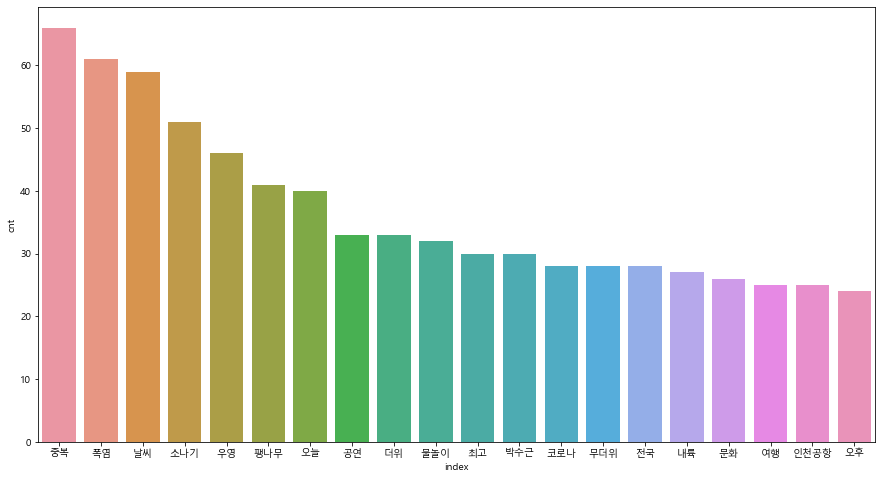

In [79]:
plt.figure(figsize = (15,8))
sns.barplot(x='index', y='cnt', data=df_103, orient='v')

(-0.5, 1499.5, 1499.5, -0.5)

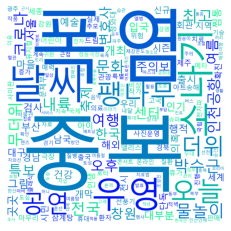

In [80]:
wordcloud = WordCloud(font_path = '../03_Visualization/dataset/malgun.ttf', 
                       background_color='white', colormap='winter', 
                       width=1500, height=1500).generate_from_frequencies(dict_count_103)

plt.imshow(wordcloud)
plt.axis('off')

## 105(IT과학) -> str_105

In [70]:
cats

{100: [264, 265, 268, 267],
 101: [259, 258, 261, 262, 260],
 103: [241, 237, 242, 248, 245],
 105: [227, 230, 283, 228]}

In [81]:
df_105 = df[(df.category == 227)|(df.category == 230)|(df.category == 283)|(df.category == 228)]

li_105 = list(df_105.news)
str_105 = ' '.join(li_105)
str_105 = re.sub('[^가-힣]+', ' ', str_105)
str_105

okt = Okt()
list_morph = okt.pos(str_105)
list_noun = []
for word, tag in list_morph:
    if (tag == 'Noun') & (len(word) > 1):
        list_noun.append(word)
print(list_noun)

count_words = Counter(list_noun).most_common()
count_words[:10]

rc('font', family='Malgun Gothic') # 한글 폰트
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호출력 설정

dict_count_105=dict(count_words)
sr = pd.Series(dict_count_105)

df_105 = pd.DataFrame(sr, columns=['cnt'])
df_105 = df_105.sort_values(by='cnt', ascending=False)[:20]
df_105.reset_index(inplace=True)
df_105.head()

['누구', '안심', '개편', '개월', '서비스', '종료', '디지털', '융합', '콘텐츠', '텔레콤', '스튜디오', '연결', '제작', '협력', '지원', '디지털', '융합', '콘텐츠', '초고', '화질', '버추', '제작', '지원', '이지스', '디지털', '트윈', '분야', '협력', '현실', '가상공간', '구축', '무선', '제도', '개선', '민관', '협의', '오프', '규제', '완화', '논의', '아이', '나라', '신인', '작가', '그림책', '콘텐츠', '상반기', '통신', '분쟁', '급증', '신청', '건수', '해결', '가장', '아이', '나라', '신인', '작가', '창작', '그림책', '서비스', '이지스', '디지털', '트윈', '사업', '확대', '업무', '협약', '체결', '스리', '데이터', '분석', '재미', '공공기관', '디지털', '행정', '서비스', '도구', '주목', '통신', '분쟁', '해결', '대폭', '상승', '이즈', '파크', '대역', '기반', '차세대', '스마트', '공장', '서비스', '실증', '착수', '헬로비전', '헬로', '전면', '개편', '압송', '전선', '수준', '국립', '전파', '연구원', '휴대', '선풍기', '전자파', '양호', '적재', '조사', '부산', '라이', '드론', '기술', '시연', '음저협', '방송', '사용', '청구', '소송', '최종', '승소', '아이', '나라', '신인', '작가', '창작', '그림책', '독점', '제공', '포스트', '우영', '하반기', '라인업', '공개', '휴대', '선풍기', '전자파', '인체', '보호', '기준', '충족', '방통위', '상반기', '통신', '분쟁', '조정', '해결', '이지스', '디지털', '트윈', '플랫폼', '구축', '티빙', '리지', '돼지', '북미', '최대', '장르', '

,index,cnt
0,반도체,42
1,투자,35
2,서비스,35
3,자동차,31
4,치료,27


<AxesSubplot:xlabel='index', ylabel='cnt'>

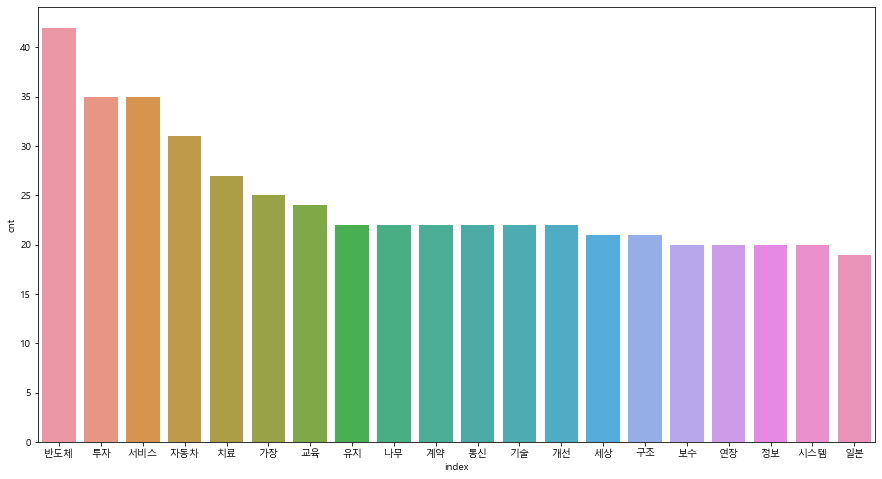

In [82]:
plt.figure(figsize = (15,8))
sns.barplot(x='index', y='cnt', data=df_105, orient='v')

(-0.5, 1499.5, 1499.5, -0.5)

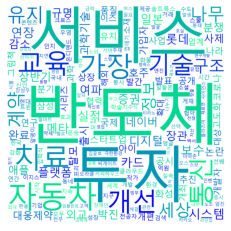

In [83]:
wordcloud = WordCloud(font_path = '../03_Visualization/dataset/malgun.ttf', 
                       background_color='white', colormap='winter', 
                       width=1500, height=1500).generate_from_frequencies(dict_count_105)

plt.imshow(wordcloud)
plt.axis('off')

## 한글만으로 된 데이터 프레임

In [120]:
df = pd.read_json('news_df.json')

In [84]:
df1 = df.copy()
df1.head()

,news,category
0,"尹 대통령 ""기업활동 위축시키는 과도한 형벌 규정 개선"" 지시",264
1,"국방부 “유엔사, 판문점 통과 허용…북송 승인 의미는 아냐”",264
2,[포토] 육군 대규모 항공작전 훈련,264
3,尹 유럽에 이어 아세안과도 정상간 비즈니스외교 시작,264
4,"국내 7대 종단 지도자들 ""이명박·이재용·김경수 통큰 사면 요청""",264


In [85]:
def onlyK(x):
    return re.sub('[^가-힣]+', ' ', x)

In [86]:
df1['news'] = df1.news.apply(lambda x : onlyK(x))

In [89]:
df1.news

0           대통령 기업활동 위축시키는 과도한 형벌 규정 개선 지시
1          국방부 유엔사 판문점 통과 허용 북송 승인 의미는 아냐 
2                        포토 육군 대규모 항공작전 훈련
3               유럽에 이어 아세안과도 정상간 비즈니스외교 시작
4       국내 대 종단 지도자들 이명박 이재용 김경수 통큰 사면 요청 
                       ...                
3049                   프랑스 유텔샛 스페이스 게 섰거라 
3050      크리스탈지노믹스 제이앤씨사이언스와 코로나 치료제 후보 발굴
3051                  세상에서 가장 작은 반도체 구조 규명
3052       클래시스 알파 복부 지방감소 효과 연구 국제학술지 게재 
3053                  부고 김윤호 플라즈마 대표이사 빙부상
Name: news, Length: 3054, dtype: object

In [102]:
len(df1.news.unique())

2164

In [103]:
df1.drop_duplicates(inplace=True, subset='news')

In [104]:
df1.news.count()

2164

In [114]:
dfk = df1.copy()

In [107]:
cats

{100: [264, 265, 268, 267],
 101: [259, 258, 261, 262, 260],
 103: [241, 237, 242, 248, 245],
 105: [227, 230, 283, 228]}

In [115]:
dfk100 = dfk[(dfk.category == cats[100][0])
             |(dfk.category == cats[100][1])
             |(dfk.category == cats[100][2])
             |(dfk.category == cats[100][3])]
dfk101 = dfk[(dfk.category == cats[101][0])
             |(dfk.category == cats[101][1])
             |(dfk.category == cats[101][2])
             |(dfk.category == cats[101][3])
             |(dfk.category == cats[101][4])]
dfk103 = dfk[(dfk.category == cats[103][0])
             |(dfk.category == cats[103][1])
             |(dfk.category == cats[103][2])
             |(dfk.category == cats[103][3])
             |(dfk.category == cats[103][4])]
dfk105 = dfk[(dfk.category == cats[105][0])
             |(dfk.category == cats[105][1])
             |(dfk.category == cats[105][2])
             |(dfk.category == cats[105][3])]

In [116]:
dfk100.head()

,news,category
0,대통령 기업활동 위축시키는 과도한 형벌 규정 개선 지시,264
1,국방부 유엔사 판문점 통과 허용 북송 승인 의미는 아냐,264
2,포토 육군 대규모 항공작전 훈련,264
3,유럽에 이어 아세안과도 정상간 비즈니스외교 시작,264
4,국내 대 종단 지도자들 이명박 이재용 김경수 통큰 사면 요청,264


In [117]:
dfk101.head()

,news,category
692,시중은행 전체로 번진 수상한 외환거래 은행 제재 불가피,259
693,현대해상 코로나로 미뤘던 해외사업 속도,259
694,년간 동일 업무 담당한 우리은행 횡령범 명령휴가 대상도 아니었다,259
695,농협금융 상반기 순이익 조 억원 사상 최대 전년 증가,259
696,신한라이프 세대 겨냥 콘텐츠로 보험 유튜브 분야 대상 수상,259


In [118]:
dfk103.head()

,news,category
1627,이종이식 한걸음 가까워진다,241
1628,세 여성 가 말하는 세까지 건강하게 사는 법 호기심 그리고 메모하기 인터뷰,241
1629,악몽도 심하면 병 벗어나는 방법은,241
1630,환경보건시민센터 휴대용 선풍기 전자파 측정,241
1631,낮잠 자주 자면 혈압 높아진다,241


In [119]:
dfk105.head()

,news,category
2455,누구 안심 개편 개월 만에 서비스 종료 왜,227
2456,디지털 융합 콘텐츠의 힘 텔레콤 스튜디오 연결로 제작 초협력 지원,227
2457,디지털 융합 콘텐츠의 힘 초고화질 버추얼 제작 지원,227
2458,이지스 디지털트윈 분야 협력 현실과 같은 가상공간 구축한다,227
2459,무선국 제도개선 민관협의체 월 초 킥오프 규제 완화 논의,227


# 모바일 주소 긁어보기

In [10]:
url = 'https://media.naver.com/press/005?sid=100'
headers = {"User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36"}

In [11]:
res = requests.get(url, headers=headers)

In [12]:
res.status_code

200

In [15]:
html = res.text

In [16]:
bs = BeautifulSoup(html, 'html.parser')

In [18]:
print(bs.prettify())

<!DOCTYPE html>
<html lang="ko">
 <head>
  <title id="browserTitleArea">
   국민일보 :: 네이버뉴스
  </title>
  <script>
   function isMobileDevice() {
		return /^.*(iPhone|iPod|iPad|Android).*/.test(navigator.userAgent);
	}
  </script>
  <script>
   (function () {
		try {
			if (isMobileDevice() && isAbleApplyPrefersColorScheme()) {
				
				document.querySelector("html").classList.add("DARK_THEME");
			}
		} catch(e) {}

		function isAbleApplyPrefersColorScheme() {
			
			if (window.matchMedia("(prefers-color-scheme)").matches === false) {
				return false;
			}

			var userAgent = navigator.userAgent;

			if (userAgent.indexOf("NAVER") > -1) {
				
				if (/.*NAVER\([a-zA-Z]*;\s[a-zA-Z]*;\s([0-9]*);/.test(userAgent)) {
					return Number(RegExp.$1) >= 1000;
				}
			} else {
				
				return document.cookie.indexOf("NSCS=1") > -1;
			}

			return false;
		}
	})();
  </script>
  <script>
   var g_ssc = 'news.v3_press' || null;
  </script>
  <meta charset="utf-8"/>
  <meta content="width=device

# 크롤링

- https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=100&sid2=265
- sid1, sid2

- https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid2=265&sid1=100&date=20220725&page=6

## 정치101 카테고리만

In [50]:
news_df = pd.DataFrame(columns=['category', 'news'])
news_df

,category,news


In [51]:
cats = [274, 265, 268, 267]
ind = 0 # 행번호
headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36"}

dt  = datetime.now()
dt = dt.strftime('_%m%d_%H%M')

In [ ]:
with open('./logs/log'+dt+'.txt', 'w') as fw:
    for cat in cats:
        fw.write('***** start : cat : ' + str(cat)+ '*****\n\n')
        
        for i in range(15):
            fw.write('*****start : i : ' + str(i) + '*****\n')
            
            url = 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid2='+str(cat)+'&sid1=100&date=20220726&page='+ str(i+1)
            res1= requests.get(url, headers=headers)
            fw.write('***** url : '+url+'\n')
            fw.write('***** status_code : ' + str(res1.status_code)+'\n')
            
            bs = BeautifulSoup(res1.text, 'html.parser')
            links = bs.select('#main_content > div > ul > li > dl > dt > a')
            fw.write('***** links in url : '+str(len(links))+'\n')
            
            newslinks = []
            for j, a in enumerate(links):
                newslink = a.get('href')
                newslinks.append(newslink)                
                fw.write('***** link : '+str(newslink)+'\n')
            newslinks = list(set(newslinks))
            
            for link in newslinks:
                res2 = requests.get(link, headers=headers)
                fw.write('***** link : '+link+'\n')
                fw.write('***** status_code : ' + str(res2.status_code)+'\n')
                
                bs2 = BeautifulSoup(res2.text, 'html.parser')
                news = bs2.find('div', id='dic_area').text
                news = re.sub('[^가-힣]+', ' ', news)
                news = re.sub('\s+', ' ', news)
                news_df.loc[ind] = [cat, news]
                fw.write('***** ind : '+str(ind)+'\tcat : '+str(cat)+'\tnews : '+news+'\n')
                ind +=1
            fw.write('***** end : i : ' + str(i) + '*****\n\n')
        fw.write('***** end : cat : ' + str(cat)+ '*****\n\n\n\n')
news_df

## 모든 카테고리

In [11]:
from datetime import datetime
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time

In [25]:
def getNewsAbout(cats):
    dt  = datetime.now()
    dt = dt.strftime('_%m%d_%H%M')
    
    ind = 0
    list_df = []
    news_df = pd.DataFrame(columns=['category', 'news'])
    
    cats = {100 : [264, 265, 268, 267], 
        101 : [259, 258, 261, 262, 260], 
        103 : [241, 237, 242, 248, 245], 
        105 : [227, 230, 283, 228] }
    
    headers = {"User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36"}
    with open('./logs/log'+dt+'.txt', 'w', encoding="UTF-8") as fw:
        # ===== 대분류 =====#
        for cat, subcats in cats.items():
            fw.write('*'*30+'\n')
            fw.write('***** start : cat : ' + str(cat)+ '*****\n\n')
            fw.write('*'*30+'\n')

            news_df = pd.DataFrame(columns=['category', 'news'])
            # ===== 소분류 =====#
            for subcat in subcats:
                fw.write('***** start : subcat : ' + str(subcat)+ '*****\n\n')
                
                # ===== 페이지 15개에 대해 크롤링 =====#
                for i in range(15):
                    print('page : ', i+1, '\tin\tsubcat : ', subcat)
                    fw.write('*****start : i : ' + str(i) + '*****\n')

                    url = 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid2='+str(subcat)+'&sid1='+str(cat)+'&date=20220727&page='+ str(i+1)

                    res1 = requests.get(url, headers=headers) 
                    time.sleep(0.3)
                    fw.write('***** url : '+url+'\n')
                    fw.write('***** status_code : ' + str(res1.status_code)+'\n')

                    # ===== 얻은 html에서 a 태그를 추출 =====#
                    bs = BeautifulSoup(res1.text, 'html.parser')
                    links = bs.select('#main_content > div > ul > li > dl > dt > a')
                    fw.write('***** links in url : '+str(len(links))+'\n')

                    # ===== 추출한 a 태그에서 href속성 값 (link) 추출 =====#
                    newslinks = []
                    for j, a in enumerate(links):
                        newslink = a.get('href')
                        newslinks.append(newslink)                
                        fw.write('***** link : '+str(newslink)+'\n')
                    newslinks = list(set(newslinks))

                    # ===== 각 link에서 기사 내용 추출 ===== #
                    for link in newslinks:
                        print("#", end="")
                        res2 = requests.get(link, headers=headers)
                        time.sleep(0.3)
                        fw.write('***** link : '+link+'\n')
                        fw.write('***** status_code : ' + str(res2.status_code)+'\n')

                        bs2 = BeautifulSoup(res2.text, 'html.parser')
                        news = bs2.find('div', id='dic_area')
                        if news:
                            news = news.text
#                             news = re.sub('[^ㄱ-ㅎ|가-힣|\w]+', ' ', news)
#                             news = re.sub('\s+', ' ', news)

                            news_df.loc[ind] = [subcat, news]
                            fw.write('***** ind : '+str(ind)+'\tcat : '+str(subcat)+'\tnews : '+news+'\n')
                            ind +=1
                    print()
                        
                    fw.write('***** end : i : ' + str(i) + '*****\n\n')
                fw.write('***** end : subcat : ' + str(subcat)+ '*****\n\n\n\n')
            fw.write('***** end : cat : ' + str(cat)+ '*****\n\n\n\n')
            list_df.append(news_df)
    return list_df

In [26]:
li_df = test_function(headers)
len(li_df)

page :  1 	in	subcat :  264
####################
page :  2 	in	subcat :  264
####################
page :  3 	in	subcat :  264
####################
page :  4 	in	subcat :  264
####################
page :  5 	in	subcat :  264
####################
page :  6 	in	subcat :  264
####################
page :  7 	in	subcat :  264
####################
page :  8 	in	subcat :  264
####################
page :  9 	in	subcat :  264
####################
page :  10 	in	subcat :  264
####################
page :  11 	in	subcat :  264
####################
page :  12 	in	subcat :  264
####################
page :  13 	in	subcat :  264
####################
page :  14 	in	subcat :  264
####################
page :  15 	in	subcat :  264
####################
page :  1 	in	subcat :  265
####################
page :  2 	in	subcat :  265
####################
page :  3 	in	subcat :  265
####################
page :  4 	in	subcat :  265
####################
page :  5 	in	subcat :  265
####################
page :  6 	in	

4

## 가짜헤더 만들기 시도

In [97]:
# headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36"}
headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)\ AppleWebKit 537.36 (KHTML, like Gecko) Chrome", "Accept":"text/html,application/xhtml+xml,application/xml;\ q=0.9,imgwebp,*/*;q=0.8"} 

In [3]:
from fake_headers import Headers

list_header = []
if __name__ == "__main__":
    header = Headers(
        browser="chrome",  # Generate only Chrome UA
        os="win",  # Generate ony Windows platform
        headers=True  # generate misc headers
    )

    for i in range(10):
        list_header.append(header.generate())

In [111]:
headers = list_header[3]

In [26]:
headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36"}
test_function(headers)

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, '현재 연결은 원격 호스트에 의해 강제로 끊겼습니다', None, 10054, None))

In [4]:
if __name__ == "__main__":
    header = Headers(
        browser="chrome",  # Generate only Chrome UA
        os="win",  # Generate ony Windows platform
        headers=True  # generate misc headers
    )
for i in range(100):
    try:
        headers = header.generate()
        list_df = test_function(headers)
    except:
        print(i , end=" ")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [14]:
if __name__ == "__main__":
    header = Headers(
        # generate any browser & os headeers
        headers=False  # don`t generate misc headers
    )

    for i in range(500):
        headers = header.generate()
        try:
            list_df = test_function(headers)
        except:
            print(i, end=' ')
            

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [19]:
if __name__ == "__main__":
    headers = Headers(os="mac", headers=True).generate()

    r = requests.get('http://whatismyheader.com/', headers=headers).text
    print(r)

GET / HTTP/1.1
Host: whatismyheader.com
User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770 Safari/537.36 OPR/57.0.3098.116
Accept-Encoding: gzip, deflate, br
Accept: */*
Connection: keep-alive
Accept-Language: en-US;q=0.5,en;q=0.3
Pragma: no-cache


(requested from: 221.146.253.123:63590)



In [20]:
headers = {'Host': 'whatismyheader.com',
'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770 Safari/537.36 OPR/57.0.3098.116',
'Accept-Encoding': 'gzip, deflate, br',
'Accept': '*/*',
'Connection': 'keep-alive',
'Accept-Language': 'en-US;q=0.5,en;q=0.3',
'Pragma': 'no-cache'}

In [21]:
li_df = test_function(headers)

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, '현재 연결은 원격 호스트에 의해 강제로 끊겼습니다', None, 10054, None))

# 크롤링한 파일

In [28]:
news_100 = pd.read_pickle('./과제0726_2_pkl/date0727_allChar/news_100.pkl')
news_101 = pd.read_pickle('./과제0726_2_pkl/date0727_allChar/news_101.pkl')
news_103 = pd.read_pickle('./과제0726_2_pkl/date0727_allChar/news_103.pkl')
news_105 = pd.read_pickle('./과제0726_2_pkl/date0727_allChar/news_105.pkl')

## .info()

In [37]:
news_100.info()
news_100.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 0 to 1094
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  1095 non-null   int64 
 1   news      1095 non-null   object
dtypes: int64(1), object(1)
memory usage: 25.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 786 entries, 0 to 1093
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  786 non-null    int64 
 1   news      786 non-null    object
dtypes: int64(1), object(1)
memory usage: 18.4+ KB


In [38]:
news_101.info()
news_101.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1402 entries, 1095 to 2496
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  1402 non-null   int64 
 1   news      1402 non-null   object
dtypes: int64(1), object(1)
memory usage: 32.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1328 entries, 1095 to 2496
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  1328 non-null   int64 
 1   news      1328 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.1+ KB


In [41]:
news_103.info()
news_103.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1372 entries, 2497 to 3868
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  1372 non-null   int64 
 1   news      1372 non-null   object
dtypes: int64(1), object(1)
memory usage: 32.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 861 entries, 2497 to 3868
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  861 non-null    int64 
 1   news      861 non-null    object
dtypes: int64(1), object(1)
memory usage: 20.2+ KB


In [43]:
news_105.info()
news_105.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 786 entries, 3869 to 4654
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  786 non-null    int64 
 1   news      786 non-null    object
dtypes: int64(1), object(1)
memory usage: 18.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 608 entries, 3869 to 4546
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  608 non-null    int64 
 1   news      608 non-null    object
dtypes: int64(1), object(1)
memory usage: 14.2+ KB


## .head()

In [33]:
news_100.head()

,category,news
0,264,"\n韓총리, 이재용·신동빈 등 '경제인' 사면 ""대통령께 건의하겠다""김한길, '국민..."
1,264,\n위원장엔 김한길 위원장…민간위원 24명 위촉윤석열 정부의 첫 대통령 직속 위원회...
2,264,"\n\n\n\n\n△김용직씨 별세, 한오섭(대통령실 국정상활실장) 빙부상 = 노원을..."
3,264,"\n27일 미국 워싱턴 D.C.서 열린 추모의 벽 준공식 기념사""한국전쟁 알리는 역..."
4,264,\n한국전 한미 전사자 새긴 '추모의벽' 준공에 축하메시지…박민식 보훈처장 대독\n...


In [34]:
news_101.head()

,category,news
1095,259,"\n금감원, 거액 이상 외환 거래 중간 검사 결과 발표은행 자체 보고 2.5조 원 ..."
1096,259,\n\n\n\n\n뉴스1국내 은행권에서 이뤄진 수상한 외환 거래 규모가 최대 7조 ...
1097,259,"\n금감원, 이상 외환 거래 검사 진행 상황 발표신한 2조5000억·우리 1조600..."
1098,259,\n외자 유출 등 거시경제 악영향환율상승·수입물가 끌어올려경기위축 대비 세밀 정책 ...
1099,259,\n\t\t\t(서울=연합뉴스) 성연재 기자 = 글로벌 렌터카 브랜드인 버젯렌터카는...


In [35]:
news_103.head()

,category,news
2497,241,\n일주일에 와인 5잔 이상은 노화 촉진\n\n\n\n과음을 하면 신체 노화가 가속...
2498,241,\n2분기 매출 22% 증가 5037억GSK 등 빅파마와 7건 대형계약신규 수주 규...
2499,241,\n\n\n\n\n비알코올성 지방간이 심부전 위험을 높인다는 연구결과가 나왔다./ ...
2500,241,"\n바나나, 치즈, 시금치 등 부작용 조심\n\n\n\n치즈는일부 항우울제와 함께 ..."
2501,241,\n\t\t\t\t\t\t\t\t\t\t연일 폭염이 이어지는 요즘. 고혈압 환자들에...


In [36]:
news_105.head()

,category,news
3869,227,\n\t\t\t SK텔레콤이 지난 5월 출시한 인공지능(AI) 서비스 '에이닷(A...
3870,227,\n\n\n\n\n스콥정보통신과 브레인네트웍스는 지난 21일 세대보안 솔루션 공급을...
3871,227,\n사장 직속 '인피니스타' 신설회사대표 맞먹는 권한 부여해신사업 '프로덕트 오너...
3872,227,\n\n\n\n\n박태훈 왓챠 대표이사가 지난 2월 왓챠의 중장기 전략에 대해 발표...
3873,227,\n8월10일 갤럭시 언팩서 색상 통일BTS 신곡 담은 최신 영상도 공개[서울경제]...


# 보충 
- 크롤링 할때 
    - ◎ 영어 숫자 한글 들을 남겨보는 것
    - △ 1500개 정도를 뽑아서 전처리하고도 1000개 이상 남도록 : 제공하는 기사가 끝? 링크 확인 필요
- okt가 한글 이외의 것도 하나?
- 각 단어가 왜? 나오는지 어떻게 알 수 있을까? 단어가 뽑혀 count된 곳의 index를 알 수 있으면 직접 확인할 수 있을 텐데
- 불용어 생각해보기